# Libraries

In [1]:
import numpy as np
import pandas as pd
# sm - https://towardsdatascience.com/simple-and-multiple-linear-regression-in-python-c928425168f9
#import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import graphviz

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
#Which search to use?
from sklearn.model_selection import GridSearchCV#, RandomizedSearchCV
#For max_depth
from sklearn.tree import DecisionTreeClassifier, plot_tree

np.random.seed(50)

#Plotting Params

%matplotlib inline

#plt.rcParams['figure.figsize'] = [20.0, 7.0]
#plt.rcParams.update({'font.size': 22,})

#sns.set_palette('viridis')
#sns.set_style('white')
#sns.set_context('talk', font_scale=0.8)

In [27]:
#Get all data
data = pd.read_csv(r'assignment1-2019-data.csv')
from sklearn.datasets import load_digits, load_iris, load_breast_cancer

digits = load_digits()
iris = load_iris()
breast_cancer = load_breast_cancer()

# Tuning Maximum Depth

- Adding an extra layer I considered to be worthwhile for a 2% improvement in accuracy
- As displayed in the breast_cancer case, there was a reduction in the accuracy before a large improvement which shows an interesting case which makes me question my rule
- Initially I tried to automate the depth selection of each dataset with my rule as above using the following code approximately. With a more robust algorithm, this type of approach would work.
~~~
exit = False
while not exit:
    value = classifier(digits, depth)
    if (value - prev) > 0.02:
        prev = value
        accuracy.append(value)
    else:
        exit = True
        accuracy.append(value)
        
    depth += 1
~~~


In [4]:
#test
#get_h_params(breast_cancer)

In [5]:
dataset = breast_cancer
#This will become a function
def classifier(dataset, depth):
    #Split into test and train 30:70
    n_samples = len(dataset.data)
    X = dataset.data.reshape((n_samples, -1))
    y = dataset.target
    X_train_dataset, X_test_dataset, y_train_dataset, y_test_dataset = train_test_split(X, y, test_size=0.30, random_state=50)
    #print(len(X_train_dataset), len(X_test_dataset))

    #K-fold on training data
    kf_data = KFold(n_splits = 6)
    for train_index, test_index in kf_data.split(X_train_dataset):
        #print("TRAIN:", train_index, "\n", "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #Classification
        estimator = DecisionTreeClassifier(max_depth=depth) #max_depth global
        estimator.fit(X_train, y_train)

        #Tree structure arrays
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left #id of left children
        children_right = estimator.tree_.children_right #id of right children
        feature = estimator.tree_.feature #feature used for splitting node
        threshold = estimator.tree_.threshold #thsh value at the node

        #i = 0
        #for X in X_test_dataset:
            #y = y_test_dataset[i]
            #prediction = predict(X)
            #print(prediction, y)
            #i+=1

        #Plot
        plot_tree(estimator.fit(dataset.data, dataset.target), filled = True, rounded = True)
        #dot_data = export_graphviz(clf, out_file=None)
        #graph = graphviz.Source(dot_data)
        #graph.render("digits")

        #accuracy = accuracy_score(y_true, y_pred)
    return(estimator.score(X_test_dataset, y_test_dataset))

    Accuracy
0   0.688889
1   0.977778
2   0.977778
3   1.000000
4   1.000000
5   1.000000
6   1.000000
7   1.000000
8   1.000000
9   1.000000
10  1.000000


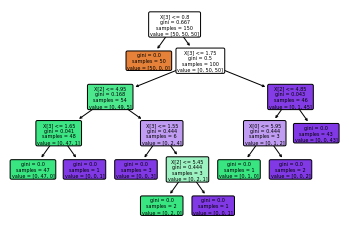

In [17]:
#Iris
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(iris, depth)
    accuracy.append(value)
        
    depth += 1
data = pd.DataFrame(accuracy, columns = ['Accuracy'])
print(data)

    Accuracy
0   0.935673
1   0.912281
2   0.988304
3   0.988304
4   0.994152
5   1.000000
6   1.000000
7   1.000000
8   1.000000
9   1.000000
10  1.000000


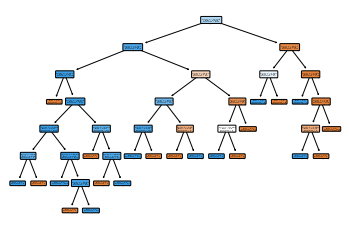

In [18]:
#Breast Cancer
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(breast_cancer, depth)
    accuracy.append(value)
        
    depth += 1
data = pd.DataFrame(accuracy, columns = ['Accuracy'])
print(data)

    Accuracy
0   0.222222
1   0.342593
2   0.488889
3   0.596296
4   0.709259
5   0.816667
6   0.881481
7   0.929630
8   0.964815
9   0.988889
10  0.996296


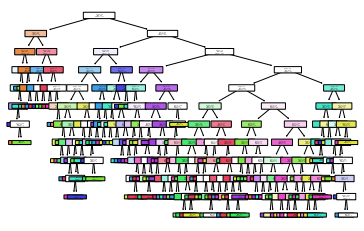

In [19]:
#Digits
exit = False
depth = 1
prev = 0
accuracy = []
while depth <= 11:
    value = classifier(digits, depth)
    accuracy.append(value)
        
    depth += 1
data = pd.DataFrame(accuracy, columns = ['Accuracy'])
print(data)

# DT vs Linear Models

- Hypothesis which performs well on one class of problems may be bad on another.
- Need to **Construct a binary classsification problem**
    - Define a function that describes the class lable of a point.
    - We know T/F value since we define the problem.
    - Generate training and testing data where P and N represent the + and - classes.
- Investigate how tree sizes affect performance
- Create visualisation of actual and learned class boundaries
- Discuss what would happen if the problem was Rd instead of R2

- Using dataset of irises petal length vs sepal length

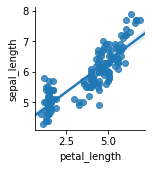

In [59]:
iris_sns = sns.load_dataset("iris")
graphs = sns.pairplot(iris_sns, kind="reg", x_vars = ["petal_length"], y_vars = ["sepal_length"])

# Regression on Mixed Data Types

- Given data set for a regression problem
- Need to train linear regression model
- Needs to be linear in weights and features 
- Has a categorical feature with more than two levels
- Use entire dataset for training
- Needs to output
    - Mean Squared Error
    - R^2
    - Round coefficients to intigers
    - Write a case based definition of the functions identified
        - Linear expression of input variables
        - One expression per level of variable
    - Describe how regression was used
    - How a new datapoint can be assigned a predicted value

In [11]:
#Code for Regression goes here.